# 03 - Richer set of features

In this notebook I add more features, including:
* AOV
* Time based features
* Categorical
* ...


In [3]:

import sys
import polars as pl

sys.path.append('../pipeline')
from dataset import CSVDataset, KaggleDataset
from evaluate import Evaluator


In [6]:
# kaggle_dataset = KaggleDataset()
# kaggle_dataset.load()

In [4]:
dataset = CSVDataset('../data/',["articles.csv","transactions_train.csv","customers.csv"])
dataset.load()


Loading ../data/articles.csv
Loading ../data/transactions_train.csv
Loading ../data/customers.csv



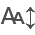

t_dat,customer_id,article_id,price,sales_channel_id
date,str,str,f64,i64
2018-09-20,"""000058a12d5b43e67d225668fa1f8d…","""0663713001""",0.050831,2


In [7]:
query = '''
    SELECT *
    FROM transactions
    LIMIT 1
'''

swallow = dataset.run_query_display_results(query)

In [13]:
from datetime import date, timedelta

# Eventually I will be creating complex features so query will likely be generated
# and then there will be windows of responses and features as well
# I'm undecided at this point so I might simply put this in a class with three methods
# one to get features, one to get label, and one to get backtest

class QueryConstants:
    end_date=date(2020,9,22)
    feature_duration=365
    label_duration=30
    backtest_duration=30
    label_end =  end_date - timedelta(days=backtest_duration)
    feature_end = label_end - timedelta(days=label_duration)
    feature_start = feature_end - timedelta(days=feature_duration)

response_query = """
        SELECT
            t.customer_id,
            MAX(
                CASE
                    WHEN t.t_dat > DATE '{response_start}'  AND t.t_dat <= DATE '{response_end}'  THEN 1
                    ELSE 0
                END
            ) AS label
        FROM transactions t
        INNER JOIN customers c ON c.customer_id = t.customer_id
        GROUP BY t.customer_id
"""

# feature_query = """
#             SELECT
#                 t.customer_id
#                 ,COUNT(1) total_transaction_items
#                 ,MAX(t.t_dat) - DATE '{feature_end}' as days_since_last
#                 ,ROUND(590*SUM(price)) as total_revenue --See Kaggle compition news group regarding the 590 factor - todo: get link
#                 ,COUNT(DISTINCT t.t_dat) as total_transactions
#             FROM transactions t
#             WHERE t.t_dat <= DATE '{feature_end}' and t.t_dat > DATE '{feature_start}'
#             GROUP BY t.customer_id
# """

feature_query = '''
    SELECT
        t.customer_id
        ,SUM(
            CASE
                WHEN t.t_dat BETWEEN DATE '{feature_end}' - INTERVAL 7 DAY AND DATE '{feature_end}' THEN 1
                ELSE 0
            END
        ) count_l7d
        ,SUM(
            CASE
                WHEN t.t_dat BETWEEN DATE '{feature_end}' - INTERVAL 28 DAY AND DATE '{feature_end}' - INTERVAL 7 DAY THEN 1
                ELSE 0
            END
        ) count_prior_21_days
        ,SUM(
            CASE
                WHEN t.t_dat BETWEEN DATE '{feature_end}' - INTERVAL (2*28) DAY AND DATE '{feature_end}' - INTERVAL 28 DAY THEN 1
                ELSE 0
            END
        ) count_prior_month_2
        ,SUM(
            CASE
                WHEN t.t_dat BETWEEN DATE '{feature_end}' - INTERVAL (3*28) DAY AND DATE '{feature_end}' - INTERVAL (2*28) DAY THEN 1
                ELSE 0
            END
        ) count_prior_month_3
        ,SUM(
            CASE
                WHEN t.t_dat BETWEEN DATE '{feature_end}' - INTERVAL (6*28) DAY AND DATE '{feature_end}' - INTERVAL (3*28) DAY THEN 1
                ELSE 0
            END
        ) count_prior_3_months
        ,SUM(
            CASE
                WHEN t.t_dat BETWEEN DATE '{feature_end}' - INTERVAL (12*28) DAY AND DATE '{feature_end}' - INTERVAL (6*28) DAY THEN 1
                ELSE 0
            END
        ) count_prior_6_months
        ,COUNT(1) total_transaction_items
        ,MAX(t.t_dat) - DATE '{feature_end}' as days_since_last
        ,ROUND(590*SUM(price)) as total_revenue
        ,COUNT(DISTINCT t.t_dat) as total_transactions
        ,ROUND(ROUND(590*SUM(price))/COUNT(DISTINCT t.t_dat)) as aov

    FROM transactions t
    WHERE t.t_dat <= DATE '{feature_end}' and t.t_dat > DATE '{feature_start}'
    --and customer_id = '00d40c65c316c02eac7fb0c628afbf57d616eed4b08f69ecfc115ca643a308af'
    GROUP BY t.customer_id
'''

label_query = response_query.format(response_start=QueryConstants.feature_end, response_end=QueryConstants.label_end)
backtest_response_query = response_query.format(response_start=QueryConstants.label_end, response_end=QueryConstants.end_date)

arrow_table = dataset.duckdb_conn.execute(label_query).fetch_arrow_table()
label_df = pl.from_arrow(arrow_table)

arrow_table = dataset.duckdb_conn.execute(backtest_response_query).fetch_arrow_table()
backtest_response_df = pl.from_arrow(arrow_table)

query = feature_query.format(**vars(QueryConstants))
arrow_table = dataset.duckdb_conn.execute(query).fetch_arrow_table()
feature_df = pl.from_arrow(arrow_table)


display(feature_df)


shape: (984_110, 12)
┌────────────┬────────────┬────────────┬───────────┬───┬───────────┬───────────┬───────────┬───────┐
│ customer_i ┆ count_l7d  ┆ count_prio ┆ count_pri ┆ … ┆ days_sinc ┆ total_rev ┆ total_tra ┆ aov   │
│ d          ┆ ---        ┆ r_21_days  ┆ or_month_ ┆   ┆ e_last    ┆ enue      ┆ nsactions ┆ ---   │
│ ---        ┆ decimal[38 ┆ ---        ┆ 2         ┆   ┆ ---       ┆ ---       ┆ ---       ┆ f64   │
│ str        ┆ ,0]        ┆ decimal[38 ┆ ---       ┆   ┆ i64       ┆ f64       ┆ i64       ┆       │
│            ┆            ┆ ,0]        ┆ decimal[3 ┆   ┆           ┆           ┆           ┆       │
│            ┆            ┆            ┆ 8,0]      ┆   ┆           ┆           ┆           ┆       │
╞════════════╪════════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════╡
│ ae98e9f609 ┆ 0          ┆ 2          ┆ 0         ┆ … ┆ -27       ┆ 119.0     ┆ 6         ┆ 20.0  │
│ cb5f03219f ┆            ┆            ┆           ┆   ┆           ┆           ┆           ┆       │
│ db3f380579 ┆            ┆            ┆           ┆   ┆           ┆           ┆           ┆       │
│ …          ┆            ┆            ┆           ┆   ┆           ┆           ┆           ┆       │
│ aea09e1e5a ┆ 0          ┆ 0          ┆ 0         ┆ … ┆ -152      ┆ 308.0     ┆ 9         ┆ 34.0  │
│ dc6837d415 ┆            ┆            ┆           ┆   ┆           ┆           ┆           ┆       │
│ f6393685ac ┆            ┆            ┆           ┆   ┆           ┆           ┆           ┆       │
│ …          ┆            ┆            ┆           ┆   ┆           ┆           ┆           ┆       │
│ af51efc2d4 ┆ 0          ┆ 1          ┆ 11        ┆ … ┆ -27       ┆ 1344.0    ┆ 20        ┆ 67.0  │
│ 8224a2dd2c ┆            ┆            ┆           ┆   ┆           ┆           ┆           ┆       │
│ fda950196e ┆            ┆            ┆           ┆   ┆           ┆           ┆           ┆       │
│ …          ┆            ┆            ┆           ┆   ┆           ┆           ┆           ┆       │
│ afca0bdfe8 ┆ 3          ┆ 39         ┆ 43        ┆ … ┆ -3        ┆ 7723.0    ┆ 100       ┆ 77.0  │
│ 8b260ffce7 ┆            ┆            ┆           ┆   ┆           ┆           ┆           ┆       │
│ 03979fd58c ┆            ┆            ┆           ┆   ┆           ┆           ┆           ┆       │
│ …          ┆            ┆            ┆           ┆   ┆           ┆           ┆           ┆       │
│ afd26a7156 ┆ 0          ┆ 2          ┆ 2         ┆ … ┆ -21       ┆ 311.0     ┆ 16        ┆ 19.0  │
│ 84cbca639d ┆            ┆            ┆           ┆   ┆           ┆           ┆           ┆       │
│ 3f4b9988f4 ┆            ┆            ┆           ┆   ┆           ┆           ┆           ┆       │
│ …          ┆            ┆            ┆           ┆   ┆           ┆           ┆           ┆       │
│ …          ┆ …          ┆ …          ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …     │
│ 099c1b704d ┆ 1          ┆ 0          ┆ 0         ┆ … ┆ -1        ┆ 36.0      ┆ 1         ┆ 36.0  │
│ 2ea686ffa2 ┆            ┆            ┆           ┆   ┆           ┆           ┆           ┆       │
│ 4012d53b73 ┆            ┆            ┆           ┆   ┆           ┆           ┆           ┆       │
│ …          ┆            ┆            ┆           ┆   ┆           ┆           ┆           ┆       │
│ 0faabb6919 ┆ 1          ┆ 0          ┆ 0         ┆ … ┆ -1        ┆ 50.0      ┆ 1         ┆ 50.0  │
│ df3deea86e ┆            ┆            ┆           ┆   ┆           ┆           ┆           ┆       │
│ 2caae6ad7c ┆            ┆            ┆           ┆   ┆           ┆           ┆           ┆       │
│ …          ┆            ┆            ┆           ┆   ┆           ┆           ┆           ┆       │
│ 12f31f276c ┆ 5          ┆ 0          ┆ 0         ┆ … ┆ -1        ┆ 102.0     ┆ 1         ┆ 102.0 │
│ 8e8091b324 ┆            ┆            ┆           ┆   ┆           ┆           ┆           ┆       │
│ aea2bfc076 ┆            ┆            ┆


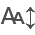

shape: (47, 2)
┌────────────┬──────────┐
│ t_dat      ┆ count(1) │
│ ---        ┆ ---      │
│ date       ┆ i64      │
╞════════════╪══════════╡
│ 2020-07-21 ┆ 2        │
│ 2020-07-13 ┆ 2        │
│ 2020-07-09 ┆ 6        │
│ 2020-06-26 ┆ 1        │
│ 2020-06-23 ┆ 1        │
│ …          ┆ …        │
│ 2019-08-23 ┆ 3        │
│ 2019-08-21 ┆ 3        │
│ 2019-08-06 ┆ 2        │
│ 2019-07-31 ┆ 4        │
│ 2019-07-26 ┆ 1        │
└────────────┴──────────┘

In [11]:
# here I'm assuring I'm counting the transaction items by date interval as expected

debugging_query = """
    select t_dat, count(1) from transactions t
    where customer_id = '00d40c65c316c02eac7fb0c628afbf57d616eed4b08f69ecfc115ca643a308af'
    and t.t_dat <= DATE '{feature_end}' and t.t_dat > DATE '{feature_start}'
    group by t_dat
    order by t.t_dat desc
""".format(**vars(QueryConstants))



trans = dataset.run_query_display_results(query=debugging_query)


In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, lower_percentile=0.01, upper_percentile=99.99):
        """
        Initialize the Winsorizer with percentiles for lower and upper bounds.

        Args:
            lower_percentile (float): The lower percentile for winsorization (e.g., 5 for 5th percentile).
            upper_percentile (float): The upper percentile for winsorization (e.g., 95 for 95th percentile).
        """
        self.lower_percentile = lower_percentile
        self.upper_percentile = upper_percentile
        self.bounds_ = None  # To store computed bounds during fitting

    def fit(self, X, y=None):
        """
        Compute the lower and upper bounds for each feature in the data.

        Args:
            X (array-like): The input data (2D array).
            y (ignored): Not used, for compatibility with Scikit-learn API.
        """
        X = np.asarray(X)
        # Add debugging to check the shape of the input
        if X.ndim != 2:
            raise ValueError(f"Expected 2D input, got {X.ndim}D input with shape {X.shape}")

        # Compute bounds
        self.bounds_ = {}
        for col in range(X.shape[1]):
            self.bounds_[col] = {
                "lower": np.percentile(X[:, col], self.lower_percentile),
                "upper": np.percentile(X[:, col], self.upper_percentile),
            }
        return self

    def transform(self, X):
        """
        Apply winsorization to the data using the computed bounds.

        Args:
            X (array-like): The input data (2D array).

        Returns:
            np.ndarray: The winsorized data.
        """
        if self.bounds_ is None:
            raise ValueError("Winsorizer has not been fitted yet.")

        X = np.asarray(X)
        if X.ndim != 2:
            raise ValueError(f"Expected 2D input, got {X.ndim}D input with shape {X.shape}")

        # Apply winsorization
        X_winsorized = X.copy()
        for col, bounds in self.bounds_.items():
            X_winsorized[:, col] = np.clip(X[:, col], bounds["lower"], bounds["upper"])
        return X_winsorized


In [16]:
# preprocessing
# 1. Split train/test

from sklearn.model_selection import train_test_split

aligned_df = feature_df.join(label_df, on="customer_id")

display(aligned_df)

# Automatically separate features and labels
excluded_columns = ["customer_id", "label"]  # Columns to exclude
feature_columns = [col for col in aligned_df.columns if col not in excluded_columns]

# Split into features (X) and labels (y)
X = aligned_df.select(feature_columns).to_numpy()
y = aligned_df["label"].to_numpy()

# Step 1: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(type(X_train))
#print(X_train.shape)






shape: (984_110, 13)
┌─────────────┬────────────┬────────────┬────────────┬───┬────────────┬────────────┬───────┬───────┐
│ customer_id ┆ count_l7d  ┆ count_prio ┆ count_prio ┆ … ┆ total_reve ┆ total_tran ┆ aov   ┆ label │
│ ---         ┆ ---        ┆ r_21_days  ┆ r_month_2  ┆   ┆ nue        ┆ sactions   ┆ ---   ┆ ---   │
│ str         ┆ decimal[38 ┆ ---        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ f64   ┆ i32   │
│             ┆ ,0]        ┆ decimal[38 ┆ decimal[38 ┆   ┆ f64        ┆ i64        ┆       ┆       │
│             ┆            ┆ ,0]        ┆ ,0]        ┆   ┆            ┆            ┆       ┆       │
╞═════════════╪════════════╪════════════╪════════════╪═══╪════════════╪════════════╪═══════╪═══════╡
│ 937f4e647ad ┆ 0          ┆ 0          ┆ 0          ┆ … ┆ 216.0      ┆ 3          ┆ 72.0  ┆ 0     │
│ 7a1ba208139 ┆            ┆            ┆            ┆   ┆            ┆            ┆       ┆       │
│ 5baf8790…   ┆            ┆            ┆            ┆   ┆            ┆            ┆       ┆       │
│ 93a04206e17 ┆ 0          ┆ 0          ┆ 10         ┆ … ┆ 1137.0     ┆ 25         ┆ 45.0  ┆ 0     │
│ ac242f98997 ┆            ┆            ┆            ┆   ┆            ┆            ┆       ┆       │
│ 4388b238…   ┆            ┆            ┆            ┆   ┆            ┆            ┆       ┆       │
│ 93cc7735b7d ┆ 0          ┆ 7          ┆ 2          ┆ … ┆ 577.0      ┆ 9          ┆ 64.0  ┆ 0     │
│ 0e90e6b4e16 ┆            ┆            ┆            ┆   ┆            ┆            ┆       ┆       │
│ 42d5b8a5…   ┆            ┆            ┆            ┆   ┆            ┆            ┆       ┆       │
│ 944a91ff611 ┆ 0          ┆ 26         ┆ 7          ┆ … ┆ 796.0      ┆ 7          ┆ 114.0 ┆ 0     │
│ 5bdaa80e121 ┆            ┆            ┆            ┆   ┆            ┆            ┆       ┆       │
│ fa918d71…   ┆            ┆            ┆            ┆   ┆            ┆            ┆       ┆       │
│ 947e2baf8c8 ┆ 0          ┆ 0          ┆ 0          ┆ … ┆ 143.0      ┆ 2          ┆ 72.0  ┆ 0     │
│ e2e6a20065f ┆            ┆            ┆            ┆   ┆            ┆            ┆       ┆       │
│ 01d564e8…   ┆            ┆            ┆            ┆   ┆            ┆            ┆       ┆       │
│ …           ┆ …          ┆ …          ┆ …          ┆ … ┆ …          ┆ …          ┆ …     ┆ …     │
│ 6c2423ab0a0 ┆ 0          ┆ 1          ┆ 0          ┆ … ┆ 26.0       ┆ 1          ┆ 26.0  ┆ 0     │
│ 3bbd3d3f51f ┆            ┆            ┆            ┆   ┆            ┆            ┆       ┆       │
│ cbf3e3fe…   ┆            ┆            ┆            ┆   ┆            ┆            ┆       ┆       │
│ 6effb7a68a6 ┆ 0          ┆ 36         ┆ 0          ┆ … ┆ 351.0      ┆ 1          ┆ 351.0 ┆ 0     │
│ a078f19e8dd ┆            ┆            ┆            ┆   ┆            ┆            ┆       ┆       │
│ ce6bbc62…   ┆            ┆            ┆            ┆   ┆            ┆            ┆       ┆       │
│ 753bc214eac ┆ 0          ┆ 1          ┆ 0          ┆ … ┆ 30.0       ┆ 1          ┆ 30.0  ┆ 0     │
│ 4c857cbf848 ┆            ┆            ┆            ┆   ┆            ┆            ┆       ┆       │
│ 804f2c50…   ┆            ┆            ┆            ┆   ┆            ┆            ┆       ┆       │
│ 845b5320ed5 ┆ 0          ┆ 5          ┆ 0          ┆ … ┆ 43.0       ┆ 1          ┆ 43.0  ┆ 0     │
│ 19e63aae69d ┆            ┆            ┆            ┆   ┆            ┆            ┆       ┆       │
│ a4ac7abf…   ┆            ┆            ┆            ┆   ┆            ┆            ┆       ┆       │
│ 88825950927 ┆ 0          ┆ 1          ┆ 0          ┆ … ┆ 20.0       ┆ 1          ┆ 20.0  ┆ 0     │
│ 5daed7e5fb8 ┆            ┆            ┆            ┆   ┆            ┆            ┆       ┆       │
│ 641d1a6c…   ┆            ┆            ┆            ┆   ┆            ┆            ┆       ┆       │
└─────────────┴────────────┴────────────┴────────────┴───┴────────────┴────────────┴───────┴───────┘

<class 'numpy.ndarray'>


In [30]:
# Winsorize for extreme values

winsorizer = Winsorizer(lower_percentile=0.01, upper_percentile=99.99)

winsorizer.fit(X_train)

print(winsorizer.bounds_)
X_train_winsorized = winsorizer.transform(X_train)






{0: {'lower': 0.0, 'upper': 33.0}, 1: {'lower': 0.0, 'upper': 59.0}, 2: {'lower': 0.0, 'upper': 73.0}, 3: {'lower': 0.0, 'upper': 61.0}, 4: {'lower': 0.0, 'upper': 116.0}, 5: {'lower': 0.0, 'upper': 173.27129999990575}, 6: {'lower': 1.0, 'upper': 370.81389999971725}, 7: {'lower': -364.0, 'upper': 0.0}, 8: {'lower': 1.0, 'upper': 6963.3945999960415}, 9: {'lower': 1.0, 'upper': 88.0}, 10: {'lower': 1.0, 'upper': 865.2712999999058}}


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()

standard_scaler.fit(X_train_winsorized)

X_train_standardized = standard_scaler.transform(X_train_winsorized)

print(standard_scaler.mean_)
print(standard_scaler.scale_)

[   0.33289851    1.10861464    1.68996479    1.2881906     3.25559262
    6.40449674   15.12880585 -110.49074672  248.85378562    4.37969333
   56.92294107]
[  1.5148296    3.15688575   4.1173046    3.50617304   6.64893485
  10.75534033  21.76181527 101.63096841 390.19774555   5.30580409
  51.00272346]


In [32]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)  # Initialize SMOTE
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_standardized, y_train)
print(X_train_standardized.shape)
print(X_train_balanced.shape)
print(y_train_balanced.shape)

(787288, 11)
(1228250, 11)
(1228250,)


In [33]:
# training - cut and paste for now

import polars as pl

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
#from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

# model = LogisticRegression()
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)


model.fit(X_train_balanced, y_train_balanced)

# # Compute AUC for training set
y_train_prob = model.predict_proba(X_train_balanced)[:, 1]  # Probabilities for the positive class
train_auc = roc_auc_score(y_train_balanced, y_train_prob)
#
print(train_auc)







0.7910985238243338


Computing optimal Threshold: 0.38
Computing predictions...
AUC: 0.79
Optimal Threshold: 0.38
Maximum F1 Score: 0.74
              precision    recall  f1-score   support

           0       0.78      0.56      0.65    614125
           1       0.66      0.84      0.74    614125

    accuracy                           0.70   1228250
   macro avg       0.72      0.70      0.69   1228250
weighted avg       0.72      0.70      0.69   1228250



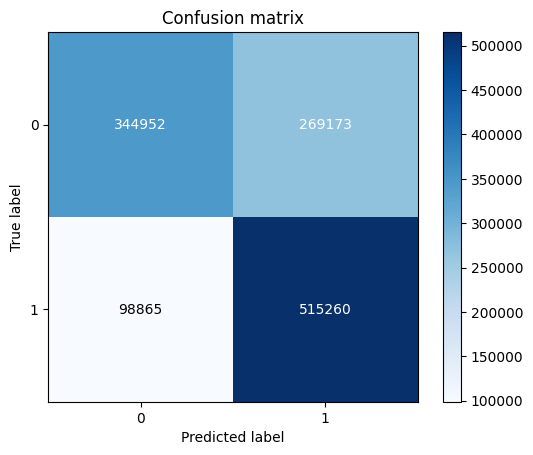

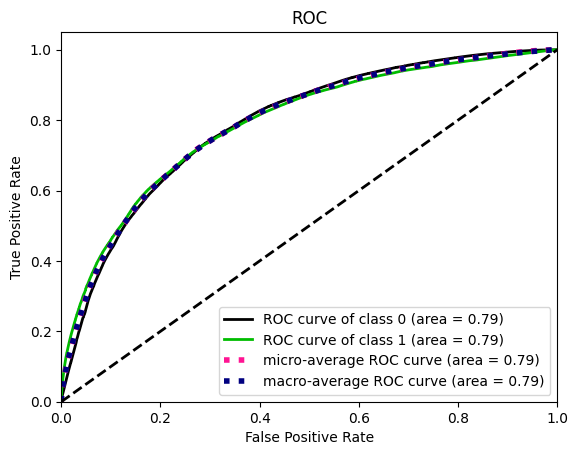

In [34]:
e_train = Evaluator(y_train_balanced, y_train_prob)
e_train.display_results()

In [35]:
# score the test

X_test_winsorized = winsorizer.transform(X_test)
X_test_standardized = standard_scaler.transform(X_test_winsorized)
y_test_prob_both = model.predict_proba(X_test_standardized)
y_test_prob = y_test_prob_both[:, 1]  # Probabilities for the positive class

Computing optimal Threshold: 0.55
Computing predictions...
AUC: 0.78
Optimal Threshold: 0.55
Maximum F1 Score: 0.53
              precision    recall  f1-score   support

           0       0.88      0.78      0.83    153531
           1       0.45      0.64      0.53     43291

    accuracy                           0.75    196822
   macro avg       0.67      0.71      0.68    196822
weighted avg       0.79      0.75      0.76    196822



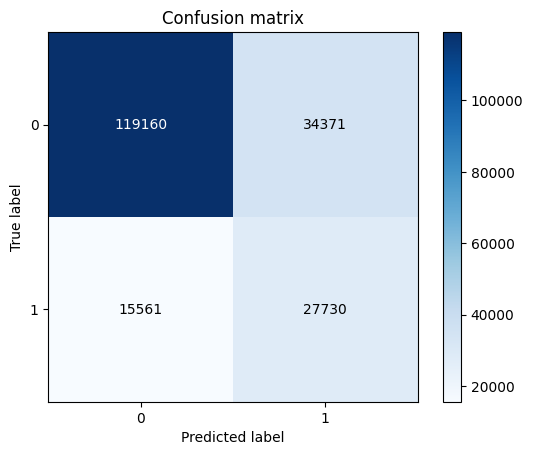

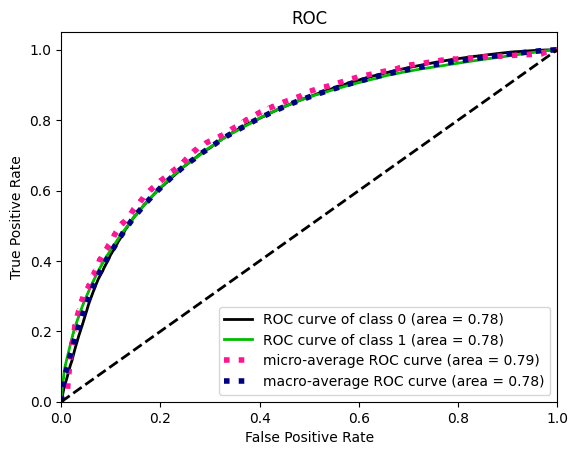

In [36]:
e_test = Evaluator(y_test, y_test_prob_both)
e_test.display_results()



In [37]:

end_date = date(2020,9,22)
feature_duration = 365
backtest_duration = 30
label_duration = 0
label_end =  end_date - timedelta(days=backtest_duration)
feature_end = label_end - timedelta(days=label_duration)
feature_start = feature_end - timedelta(days=feature_duration)


display("Initial feature_start: ", feature_start)
display("Initial feature_end: ", feature_end)
# print()

# this is nice ... I get features by just providing start and end
backtest_feature_query = feature_query.format(feature_end=feature_end, feature_start=feature_start)

# todo this is where dataset.run_query(query) would be good.  Returns DF.
arrow_table = dataset.duckdb_conn.execute(backtest_feature_query).fetch_arrow_table()
backtest_feature_df = pl.from_arrow(arrow_table)

# todo: I do not use this view
# dataset.duckdb_conn.register("backtest_features", backtest_feature_df)

print(backtest_feature_df.shape)

# I'm preparing to score records ... for scoring I think ...
# def score(model, feature_df, pk_column) and returns something reasonable .. meaning I want to return
# a dataframe with customer_id, probability (or all classes to generalize to multi-class)
# and maybe evaluation could have a different constructor that takes a DF instead?

features_without_id = backtest_feature_df.drop("customer_id")

print(features_without_id.shape)

features_without_id_winsorized = winsorizer.transform(features_without_id.to_numpy())
features_without_id_standard = standard_scaler.transform(features_without_id_winsorized)

scores_prob_positive = model.predict_proba(features_without_id_standard)[:, 1]
backtest_pred = [1 if prob >= e_test.optimal_threshold else 0 for prob in scores_prob_positive]

scores_df = pl.DataFrame({
    "customer_id": backtest_feature_df["customer_id"],
    "score": scores_prob_positive,
    "prediction": backtest_pred
})

dataset.duckdb_conn.register("scores", scores_df)

backtest_pred_truth_df = scores_df.join(backtest_response_df, on="customer_id")
backtest_response = np.array(backtest_pred_truth_df["label"])
backtest_score = np.array(backtest_pred_truth_df["score"])






'Initial feature_start: '

datetime.date(2019, 8, 24)

'Initial feature_end: '

datetime.date(2020, 8, 23)

(985282, 12)
(985282, 11)


Computing predictions...
AUC: 0.78
Optimal Threshold: 0.55
Maximum F1 Score: 0.52
              precision    recall  f1-score   support

           0       0.88      0.78      0.83    772290
           1       0.44      0.63      0.52    212992

    accuracy                           0.75    985282
   macro avg       0.66      0.71      0.67    985282
weighted avg       0.79      0.75      0.76    985282



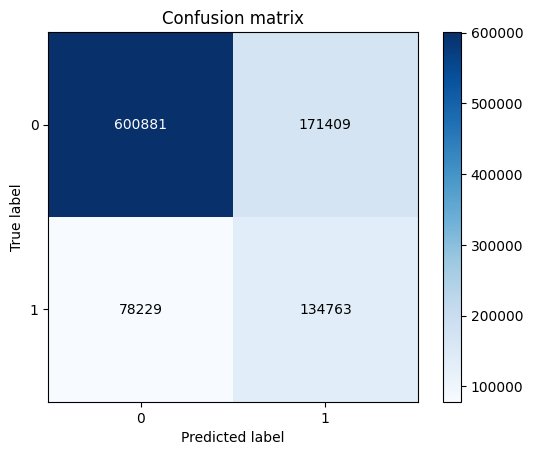

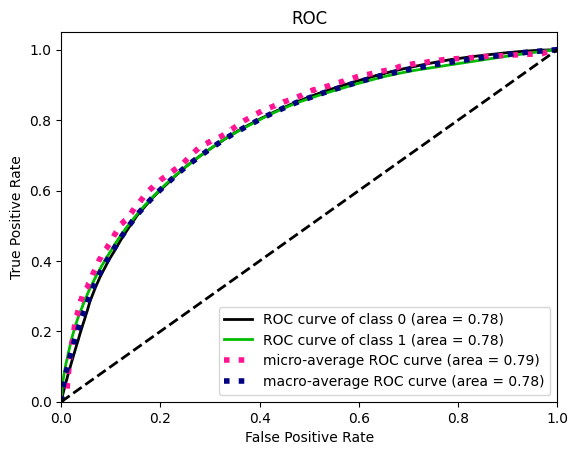

In [38]:
e_backtest = Evaluator(backtest_response, backtest_score, threshold=e_test.optimal_threshold)

e_backtest.display_results()


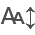

shape: (10, 4)
┌────────┬───────────────┬───────────────────────┬─────────────────┐
│ decile ┆ buyer_count   ┆ scored_customer_count ┆ non_buyer_count │
│ ---    ┆ ---           ┆ ---                   ┆ ---             │
│ i64    ┆ decimal[38,0] ┆ i64                   ┆ decimal[38,0]   │
╞════════╪═══════════════╪═══════════════════════╪═════════════════╡
│ 10     ┆ 4808          ┆ 98528                 ┆ 93720           │
│ 9      ┆ 5546          ┆ 98528                 ┆ 92982           │
│ 8      ┆ 6774          ┆ 98528                 ┆ 91754           │
│ 7      ┆ 9967          ┆ 98528                 ┆ 88561           │
│ 6      ┆ 13108         ┆ 98528                 ┆ 85420           │
│ 5      ┆ 17800         ┆ 98528                 ┆ 80728           │
│ 4      ┆ 22990         ┆ 98528                 ┆ 75538           │
│ 3      ┆ 30076         ┆ 98528                 ┆ 68452           │
│ 2      ┆ 40359         ┆ 98529                 ┆ 58170           │
│ 1      ┆ 61564         ┆ 98529                 ┆ 36965           │
└────────┴───────────────┴───────────────────────┴─────────────────┘

In [39]:
# todo this is where I want to encapsulate the display of response curve ??? or do I care
# the display can be encapsulated ... but perhaps the computatiopn of DF still stays
# in notebook for now

query = f'''

SELECT decile, SUM(bought) buyer_count, COUNT(1) scored_customer_count, COUNT(1) - SUM(bought) non_buyer_count
FROM (
    SELECT s.customer_id, ntile(10) OVER (ORDER BY score desc) AS decile, COALESCE(bought,0) as bought
    from scores s
    left outer join (
        SELECT customer_id, COUNT(distinct t.customer_id) bought
        from transactions t
        WHERE t_dat > DATE '{feature_end}'
        GROUP BY customer_id
    ) t on t.customer_id = s.customer_id
    GROUP BY s.customer_id, score, bought
) x
GROUP BY decile
ORDER BY decile DESC
'''

backtest_results = dataset.run_query_display_results(query)
# backtest - use the new features and labels code I think firstly
# scoring ... leave this open for now

# I can use the feature query constant and set the correct parameters to get the backtest features

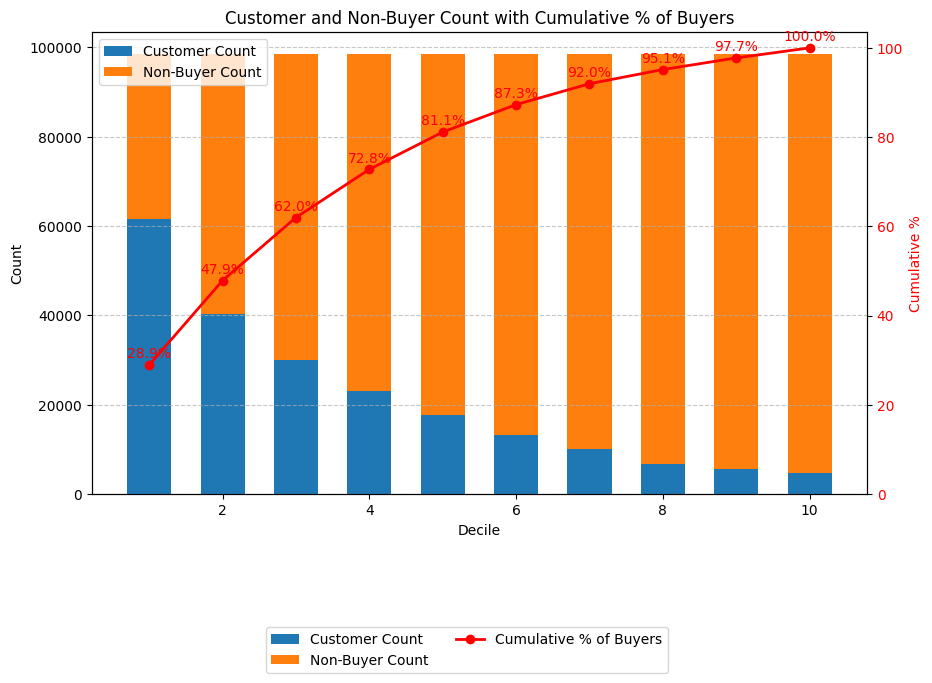

In [40]:


# plot the response curve ... put into a class
import matplotlib.pyplot as plt

# Assuming data is already created
data = backtest_results.to_pandas()

# Sort the DataFrame by decile in ascending order
data = data.sort_values(by="decile", ascending=True)

data["cumulative_percent"] = (data["buyer_count"].cumsum() / data["buyer_count"].sum() * 100)

# Extract columns as lists
decile = data["decile"].to_list()
customer_count = data["buyer_count"].to_list()
non_buyer_count = data["non_buyer_count"].to_list()
cumulative_percent = data["cumulative_percent"].to_list()

# print(cumulative_percent)
# print(customer_count)

# Create the figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the stacked bar chart
ax1.bar(decile, customer_count, label="Customer Count", width=0.6)
ax1.bar(decile, non_buyer_count, bottom=customer_count, label="Non-Buyer Count", width=0.6)

# Label for the primary y-axis
ax1.set_xlabel('Decile')
ax1.set_ylabel('Count')
ax1.set_title('Customer and Non-Buyer Count with Cumulative % of Buyers')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend(loc="upper left")

# Create a secondary y-axis for cumulative percent
ax2 = ax1.twinx()
ax2.plot(decile, cumulative_percent, color="red", marker="o", label="Cumulative % of Buyers", linewidth=2)
ax2.set_ylabel('Cumulative %', color='red')
ax2.tick_params(axis='y', labelcolor='red')

for x, y in zip(decile, cumulative_percent):
    ax2.annotate(f"{y:.1f}%", (x, y), textcoords="offset points", xytext=(0, 5), ha='center', color="red")

# Set the secondary y-axis to start at 0
ax2.set_ylim(0, ax2.get_ylim()[1])  # Start from 0, keep the max limit as it is


# Combine legends from both axes
fig.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)

# Show the plot
plt.show()

# this is not yet how I want it to look but will need to do for the time being

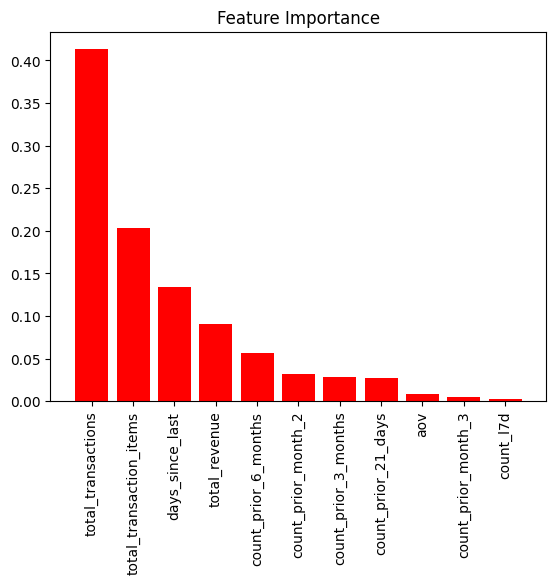

In [42]:
# importance ...

# other options for output metric display

from sklearn.metrics import classification_report


# Feature Importance
importance = model.feature_importances_
indices = np.argsort(importance)[::-1]

plt.figure()
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importance[indices], color="r", align="center")
plt.xticks(range(X.shape[1]), [feature_columns[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()